# Interrupted Time Series

Interrupted time series (ITS) analysis is econometrics approach that allows us to evaluate the impact of an intervention or policy change that occurs at a specific point in time {cite}`bernal2017interrupted`. Unlike DiD, ITS **does not require a control group** as it assumes that the data-generating process would have continued in a similar way without the introduction of the new policy.  ITS can be seen as a special case of a regression discontinuity design (RDD). In a typical RDD, the discontinuity is observed across different units based on a cutoff point. For example, the introduction of a special tax for plants over a certain size. ITS work in a similar way but instead of having the _discontinuity_ based on a specific variable, the **discontinuity occurs over time**. Then, we can model the time series of interest using a **segmented regression** approach as in:

\begin{equation}
    y = \beta_0 + \beta_1 \, \text{time} + \beta_2 \, \text{period} + \beta_3 \, \text{time after policy} + \varepsilon
\end{equation}

where the regression coefficients are used to capture:
- The baseline intercept ($\beta_0$).
- The pre-policy slope ($\beta_1$).
- The change in level at the introduction of the new policy ($\beta_2$). It should be noted that "period" is a dummy variable (0 or 1) that indicates whether the observation is from the period before the policy implementation (0) or after (1).
- The change in slope after the introduction of the new policy ($\beta_3$).

## Example
Let's now try to generate some data to try and apply this methodology in a practical example.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


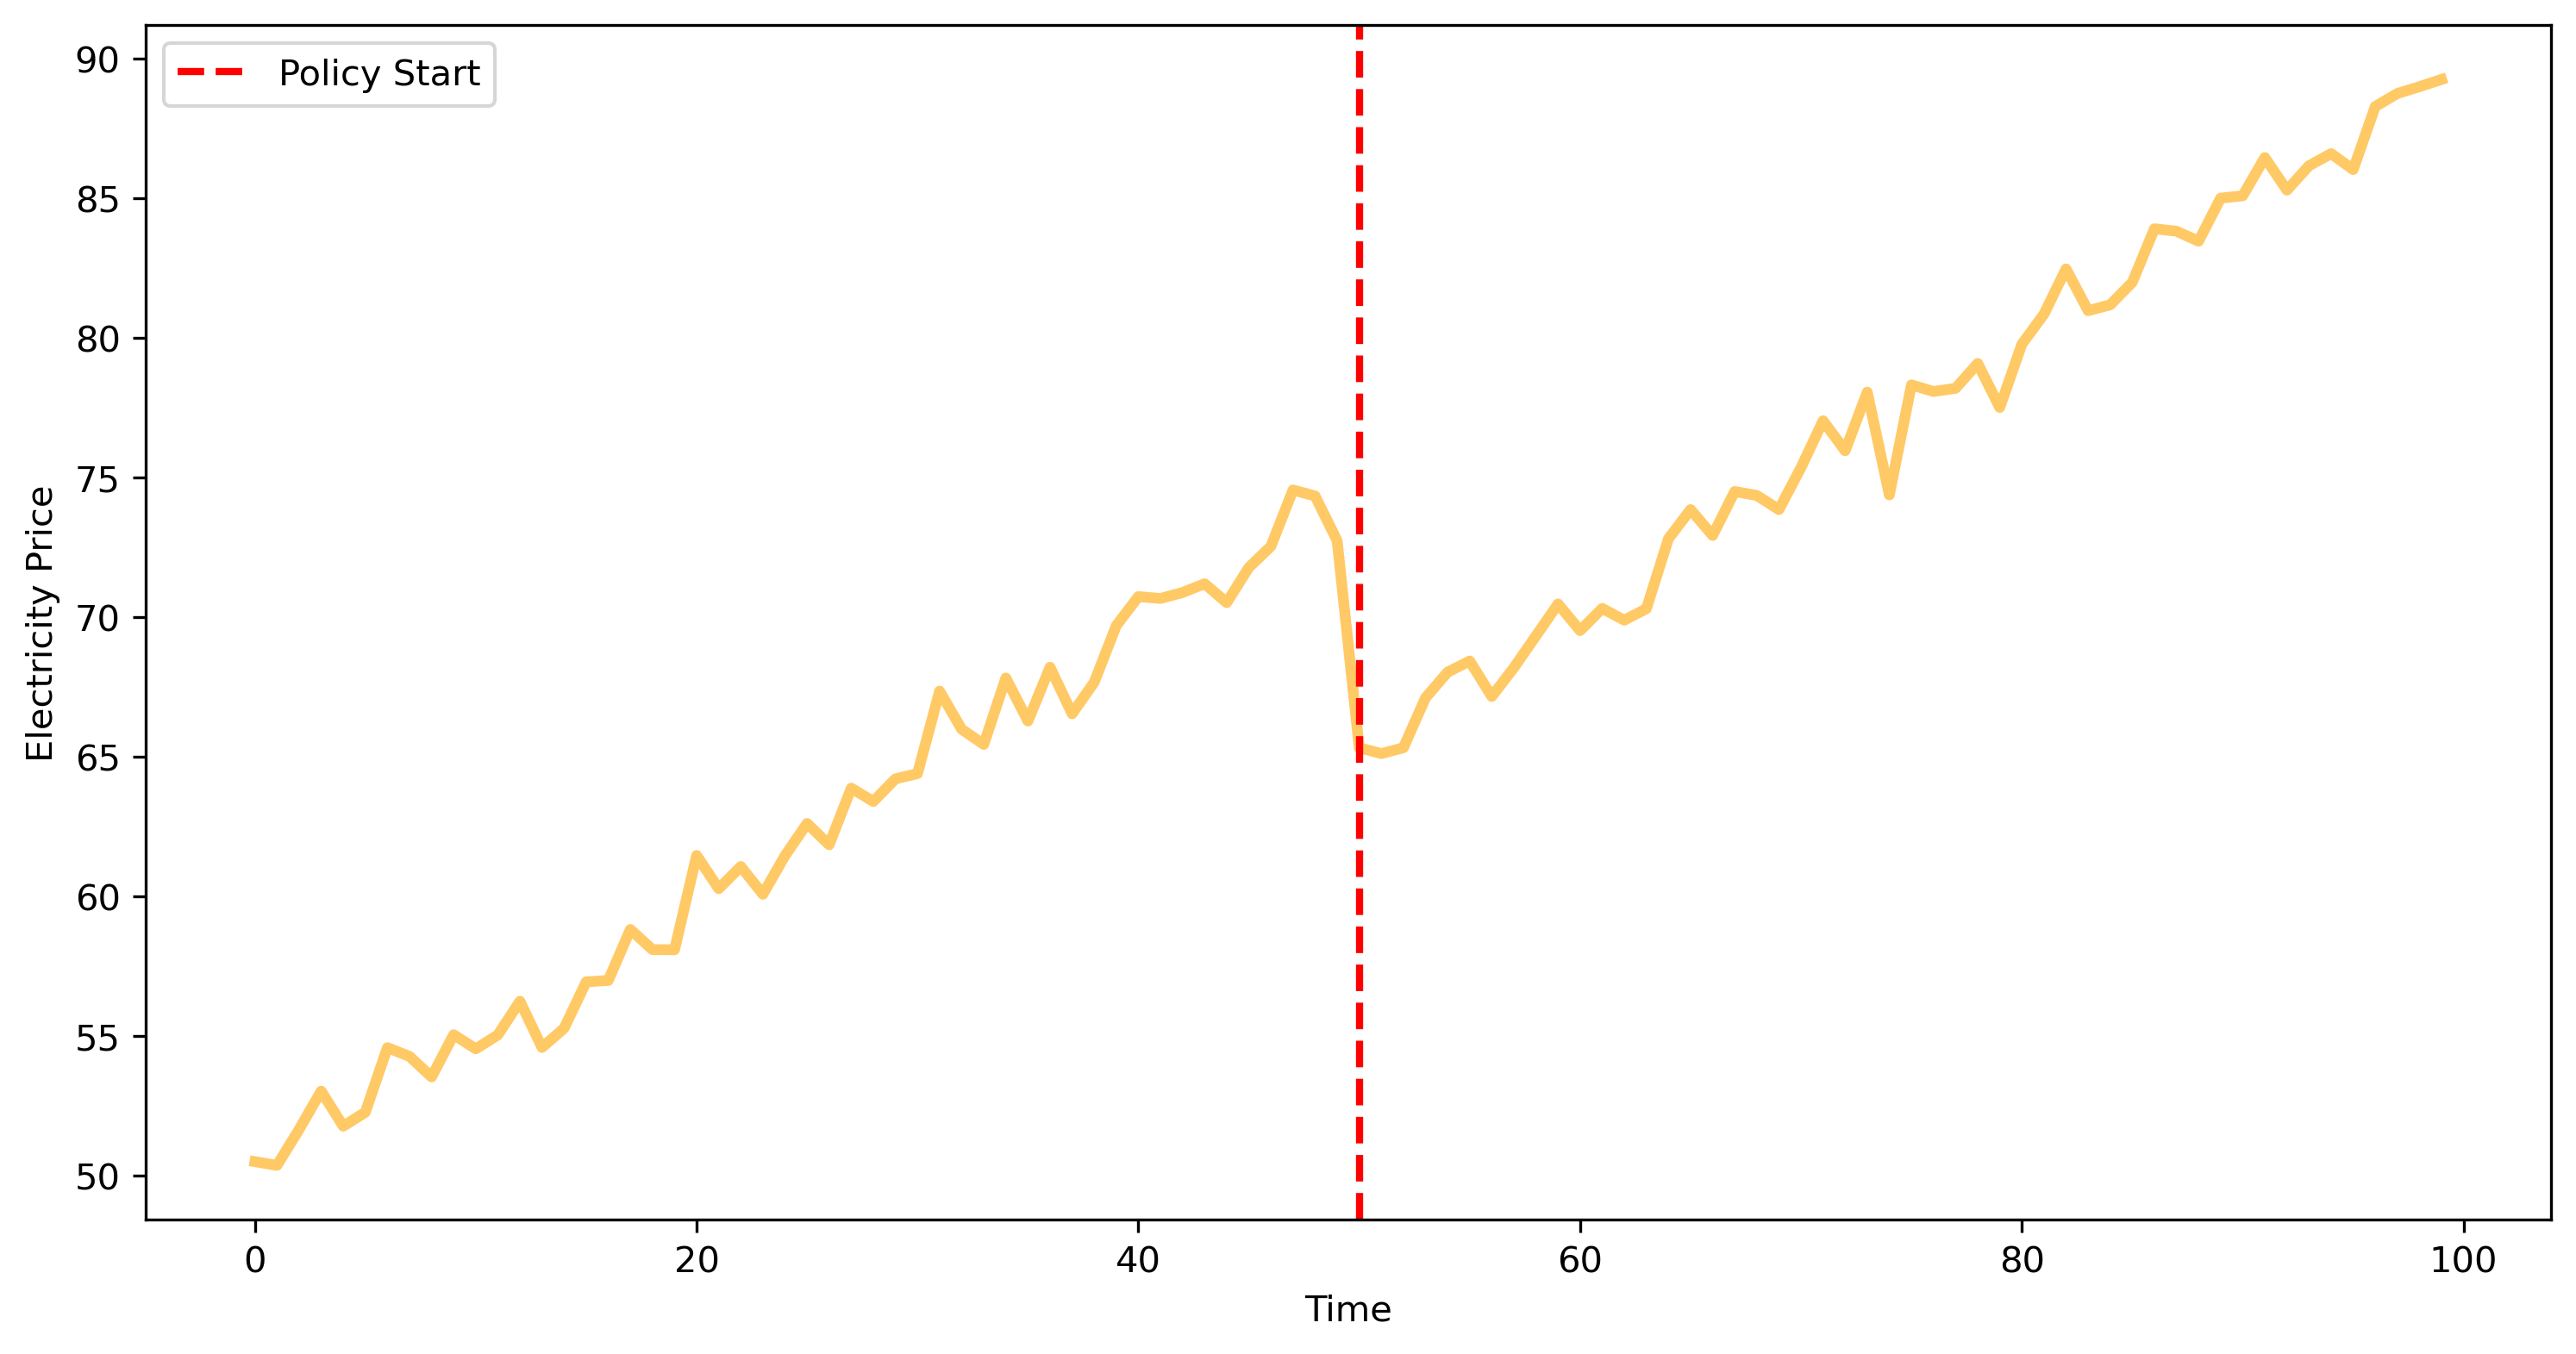

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Set random seed for reproducibility
np.random.seed(42)

# Generate time series data
n_periods = 100
time = np.arange(n_periods)
policy_start = 50  # Time when the policy starts

# Generate prices with a trend and some noise
prices = 50 + 0.5 * time + np.random.normal(scale=1, size=n_periods)

# Introduce a policy effect (e.g., a reduction in prices)
prices[policy_start:] += -10

# Create a DataFrame
data = pd.DataFrame({
    'time': time,
    'price': prices
})

# Plot the data
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(data['time'], data['price'], lw=3, alpha=.6, c='orange')
plt.axvline(policy_start, color='red', linestyle='--', label='Policy Start', lw=2)
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.legend()
plt.show()

Here, we introduced a policy at time step 50, which causes a price reduction of 10 units. Let's now create the dummy variables and fit a segmented regression model to show if we are able to estimate the effect of the policy.

In [2]:
# Create the time after policy variable
data['time_after_policy'] = np.where(data['time'] >= policy_start, data['time'] - policy_start, 0)
data['period'] = np.where(data['time'] >= policy_start, 1, 0)

import statsmodels.api as sm

# Define the independent variables
X = sm.add_constant(data[['time', 'period', 'time_after_policy']])
y = data['price']

# Fit the OLS model
model = sm.OLS(y, X).fit()
print(model.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.993
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     4425.
Date:                Thu, 19 Dec 2024   Prob (F-statistic):          9.73e-103
Time:                        12:09:18   Log-Likelihood:                -129.67
No. Observations:                 100   AIC:                             267.3
Df Residuals:                      96   BIC:                             277.8
Df Model:                           3                                         
Covariance Type:            nonrobust  

As we can see, the results show:
- The baseline price before the policy was 50 ($\beta_0$ = const).
- The prices were increasing by approximately 0.5 units per time period before the policy ($\beta_1$ = time).
- There was an immediate reduction of 9.3 units (fairly close to 10) in the price level after the policy ($\beta_2$ = period).
- The trend (slope) of prices did not significantly change after the policy ($\beta_3$ = time_after_policy).

## Preprocessing the Data

Many real-world data might be characterised by high autocorrelation or more complex dynamics. In that case, it might be useful to firts fit a model and then examine the behaviour of the residuals to estimate the effect of the policy. For example, using a time series model (e.g., SARIMA) followed by ITS analysis on the residuals might have several advantages, such as:
- Handling autocorrelation and seasonality: time series data often exhibit autocorrelation and seasonality, where current values are correlated with past values. Ignoring this aspect can lead to incorrect inferences and underestimated standard errors. By fitting a SARIMA model, we explicitly account for this, leading to more accurate residuals that reflect the underlying stochastic process.
- Isolating the intervention effect: by first modeling the time-dependent structure of the data (i.e., the autocorrelation), we can better isolate the effect of the intervention. The residuals from the SARIMA model represent the portion of the time series that is not explained by its own past values, thus providing a clearer signal of any intervention effects.

Let's try and generate some data, where we fit a SARIMA model on the pre-policy data, and use it to whiten the whole time series observed. Also in this case, we assume the **policy effect** is to reduce prices by 10 units.

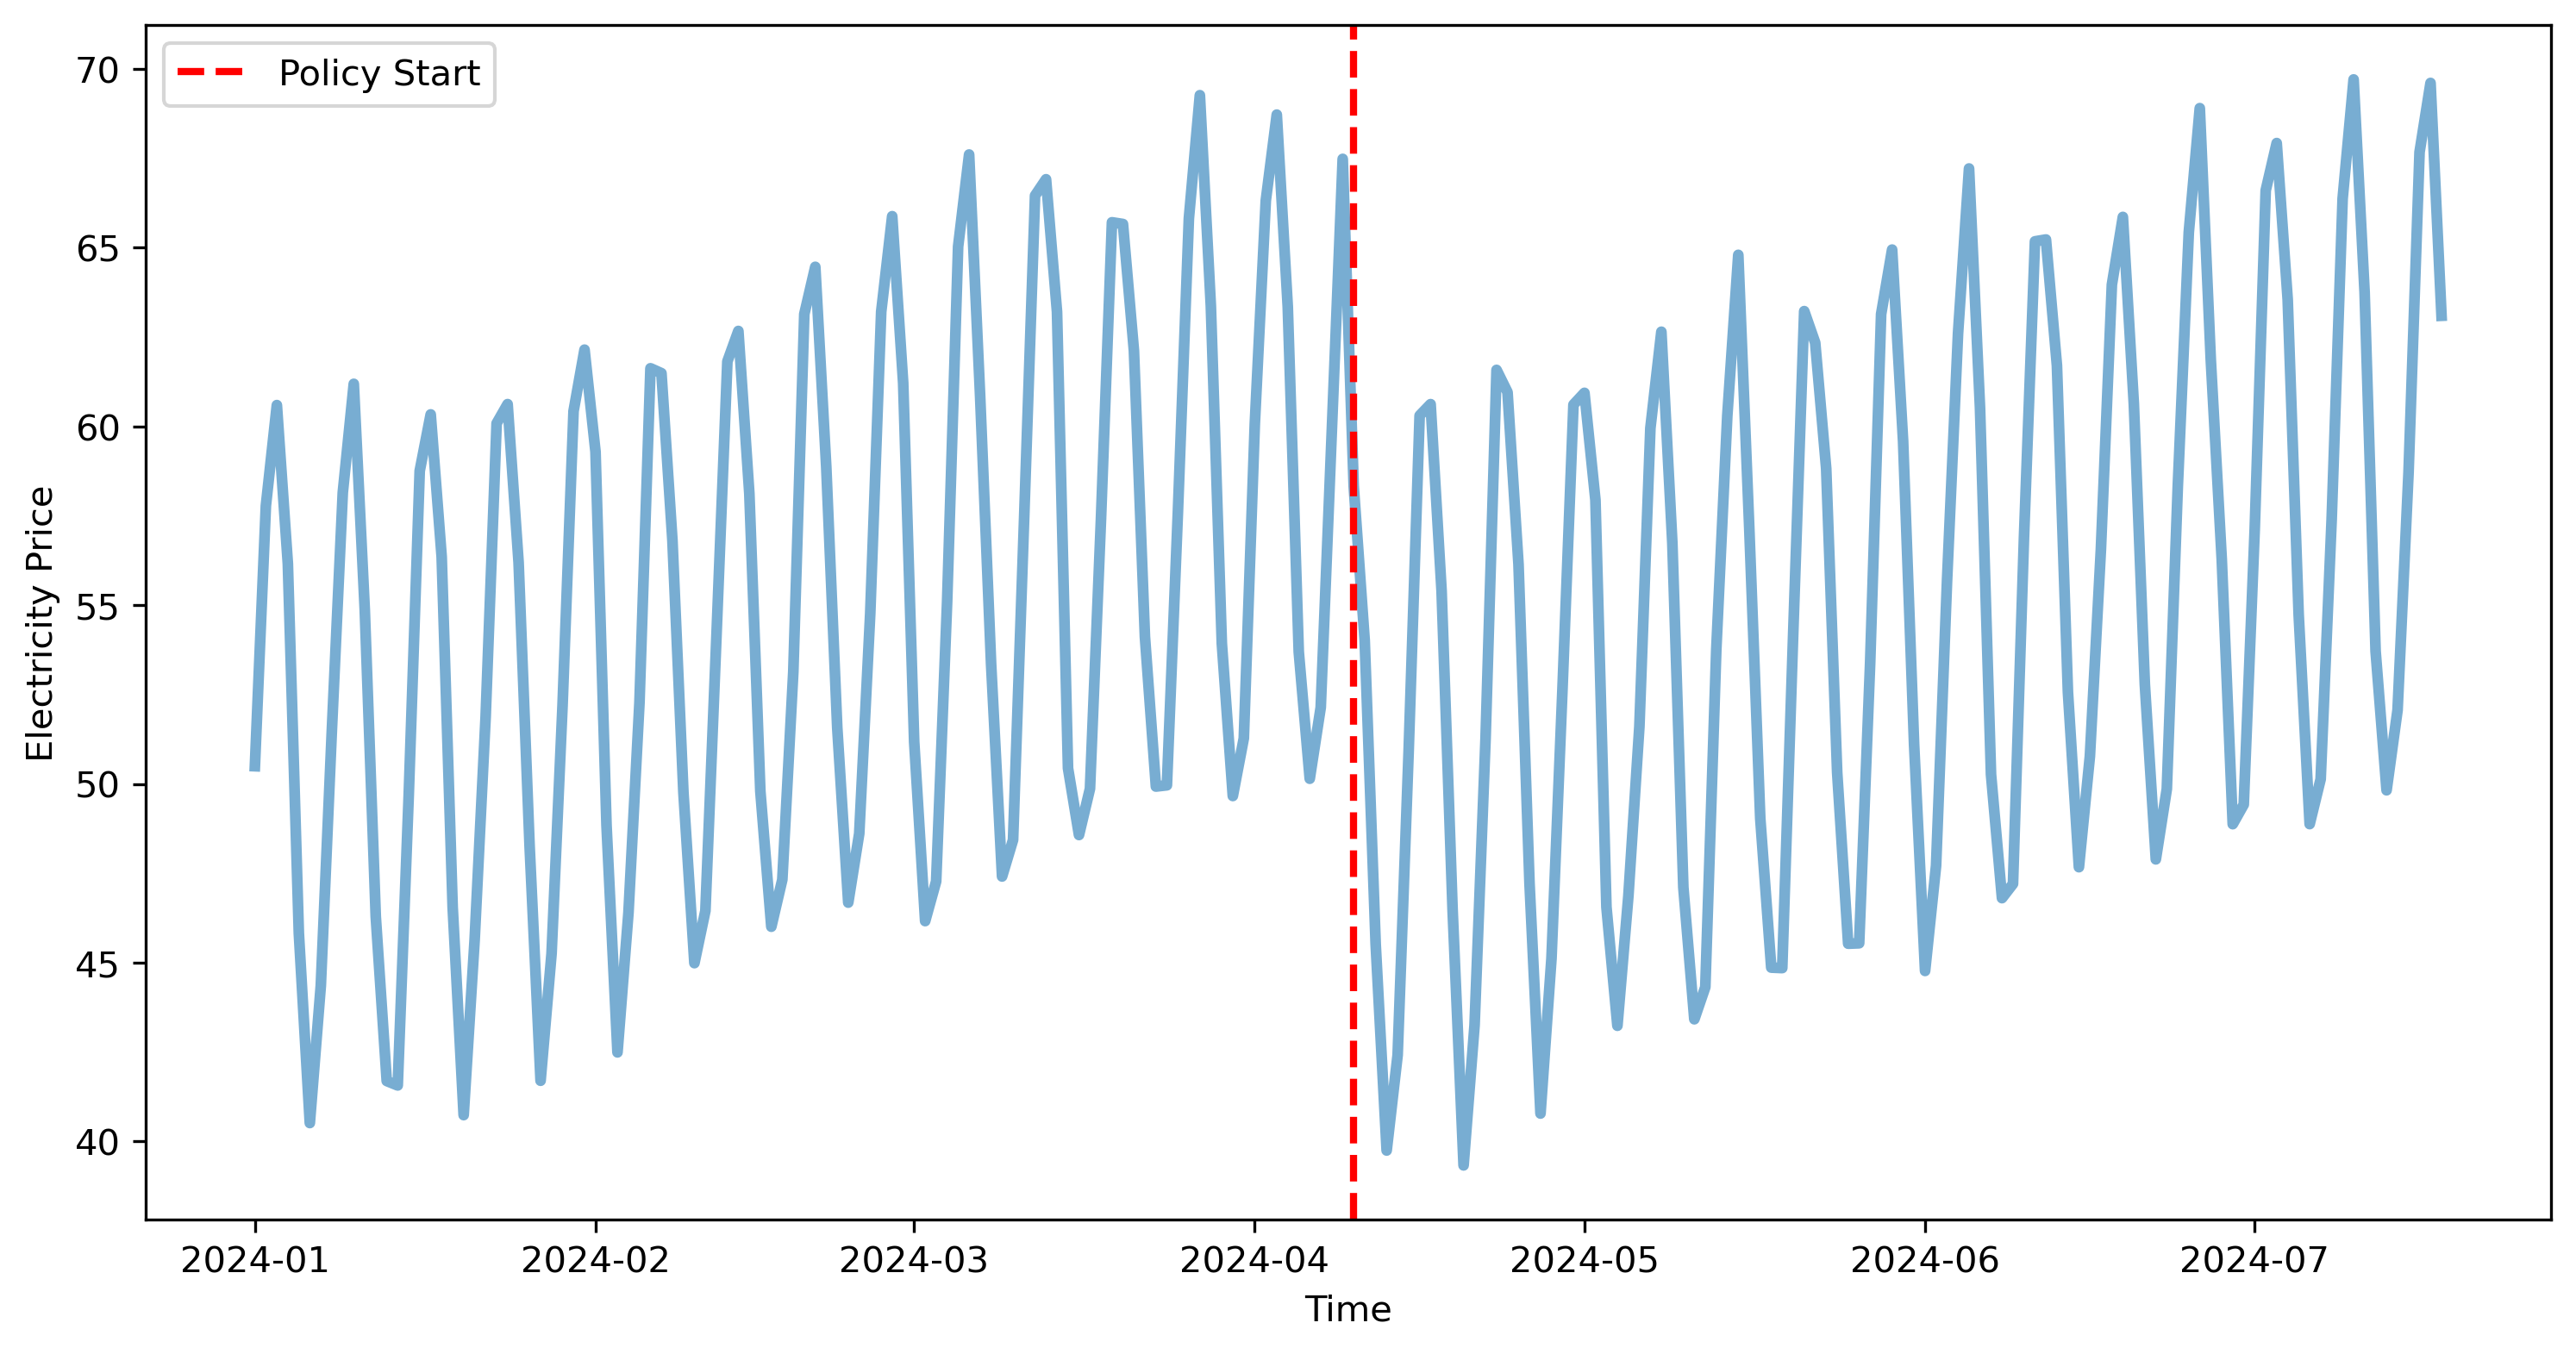

In [3]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate time series data with seasonality, trend, and some noise
n_periods = 200
time = pd.date_range(start='2024-01-01', periods=n_periods, freq='D')
seasonal_period = 7
policy_start = 100  # Time index when the policy starts

# Generate seasonal component
seasonal_effect = 10 * np.sin(2 * np.pi / seasonal_period * np.arange(n_periods))

# Generate trend component
trend_effect = 0.1 * np.arange(n_periods)

# Generate noise component
noise = np.random.normal(scale=1, size=n_periods)

# Combine components
prices = 50 + seasonal_effect + trend_effect + noise

# Introduce a policy effect (e.g., a reduction in prices)
prices[policy_start:] -= 10

# Create a DataFrame
its_data = pd.DataFrame({
    'time': time,
    'price': prices
})

# Set the index to the datetime
its_data.set_index('time', inplace=True)
its_data.index = pd.DatetimeIndex(its_data.index, freq='D')

# Plot the data
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(its_data.index, its_data['price'], lw=3, alpha=.6)
plt.axvline(its_data.index[policy_start], color='red', linestyle='--', label='Policy Start', lw=2)
plt.xlabel('Time')
plt.ylabel('Electricity Price')
plt.legend()
plt.show()

Since the policy has been introduced at the 100th observation, we can fint a SARIMA model on the first 100 observations, and then perform and ITS analysis on the reisudals.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


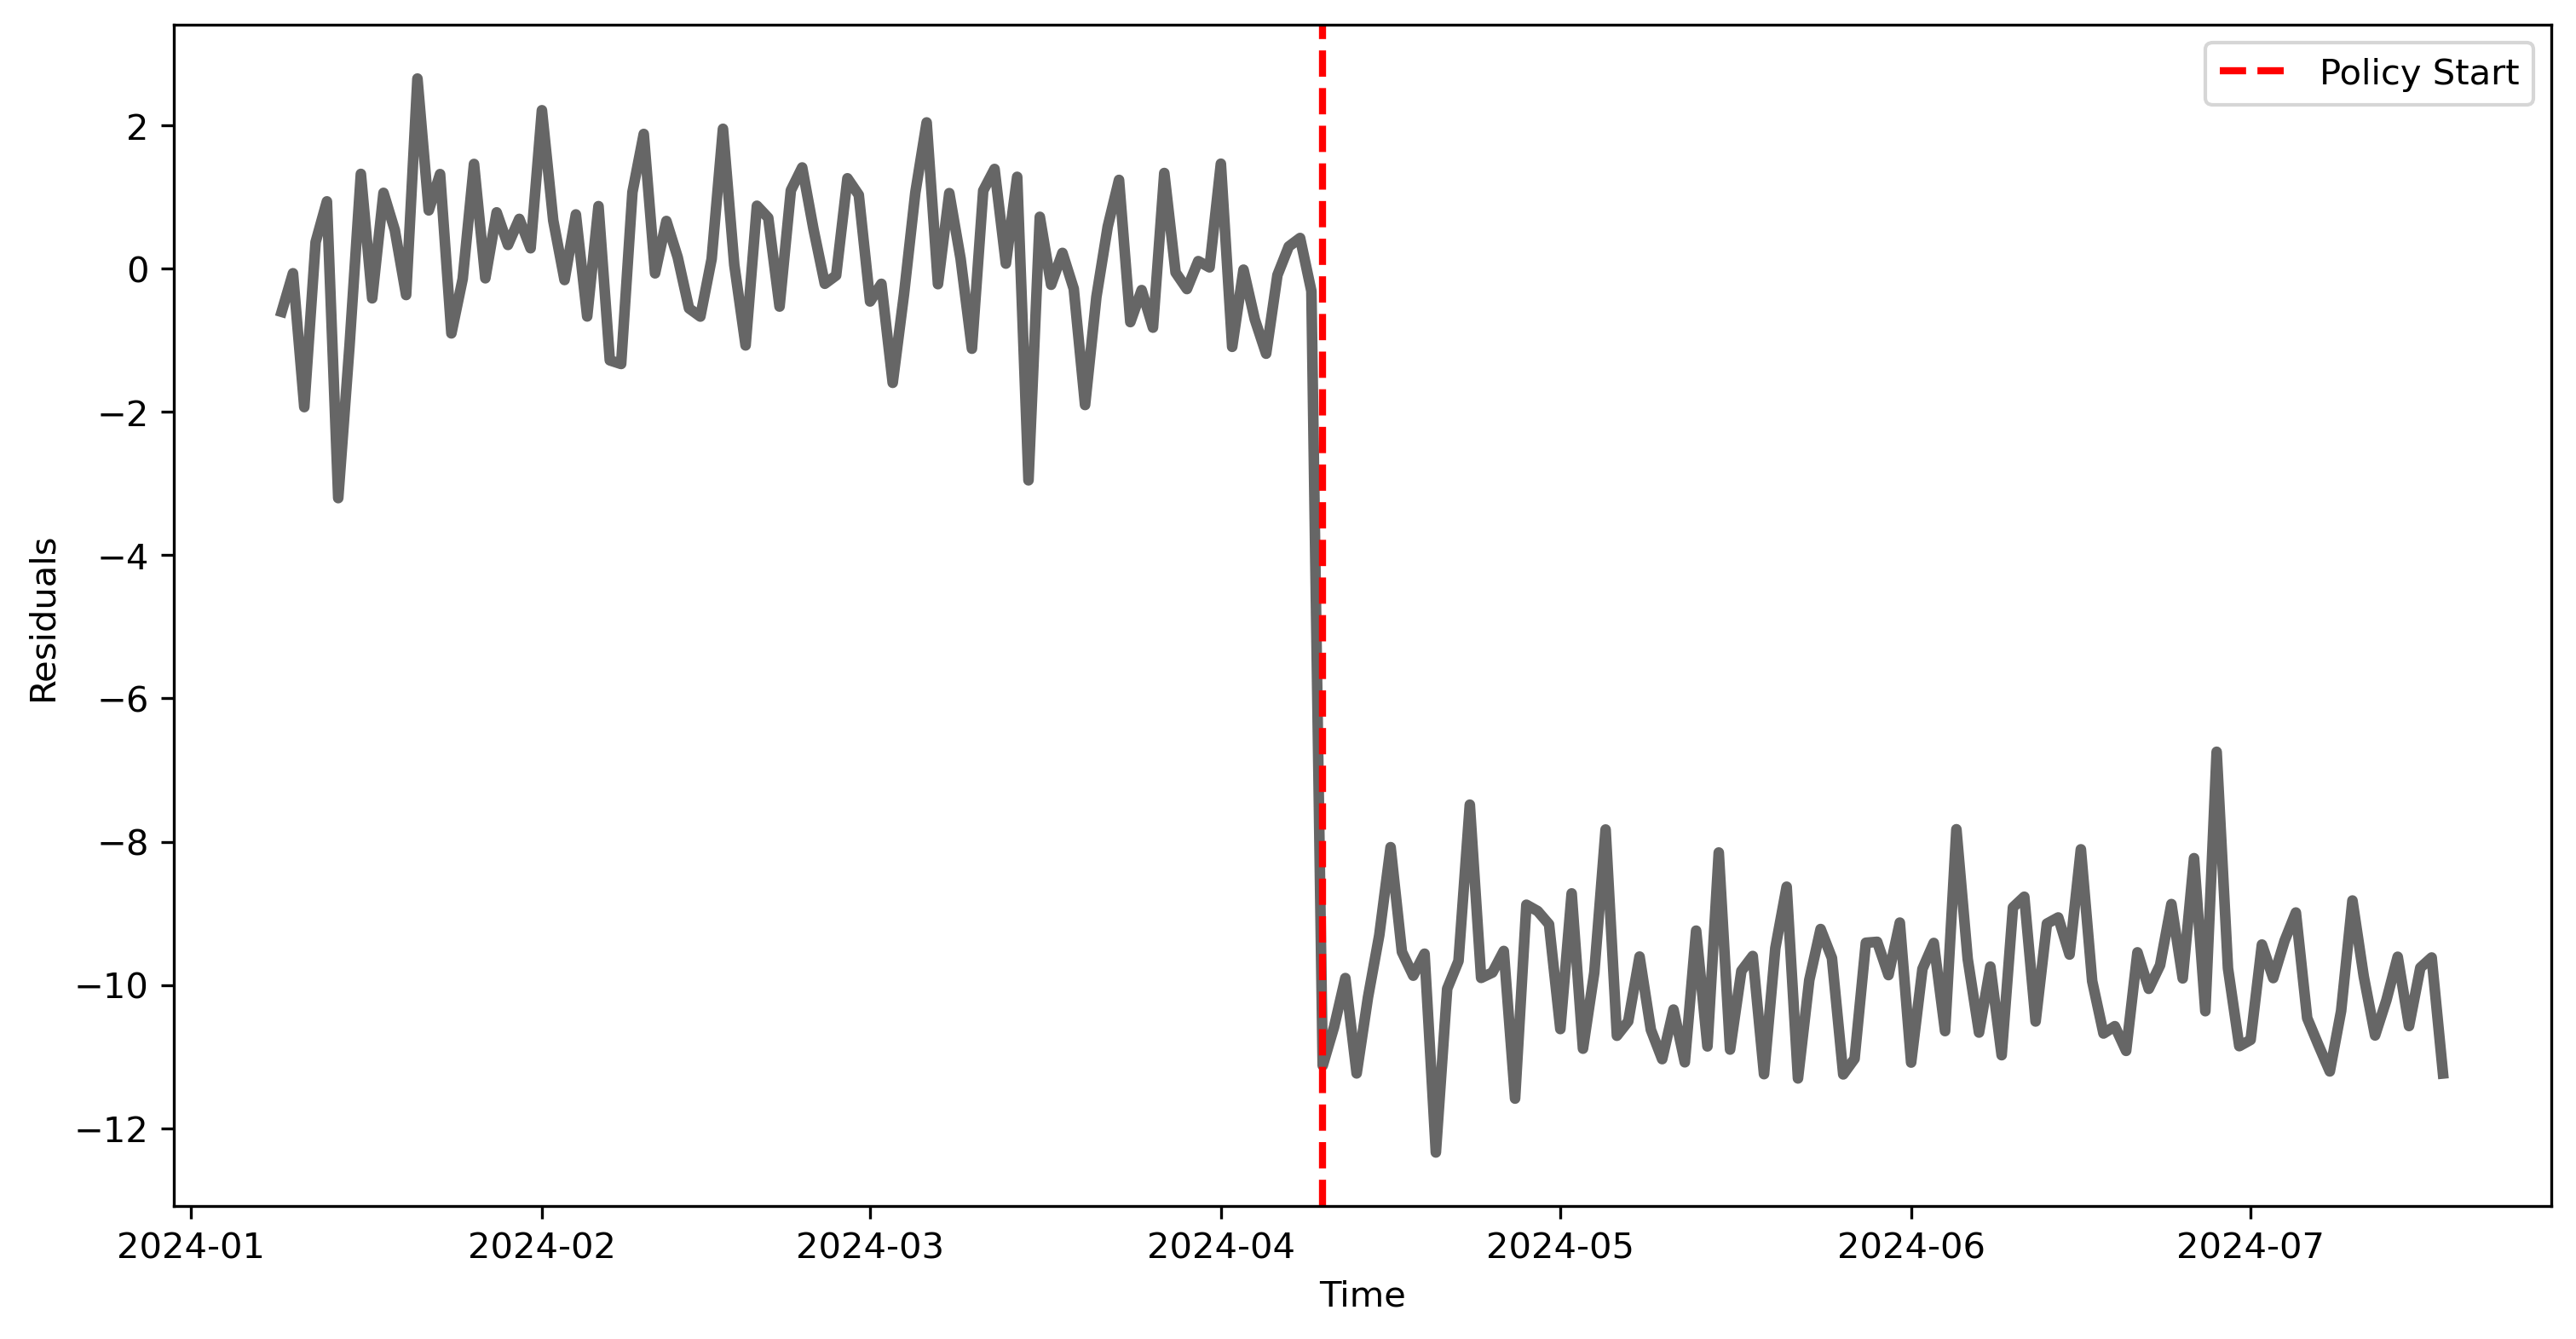

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit a SARIMA model to the pre-intervention period
pre_policy_data = its_data.iloc[:policy_start]
sarima_model = SARIMAX(pre_policy_data['price'], order=(1, 1, 1), seasonal_order=(1, 1, 1, seasonal_period)).fit(disp=False)

# Get the residuals for the entire time series
its_data['residuals'] = its_data['price'] - sarima_model.predict(start=0, end=n_periods-1, dynamic=False)

# Plot the data
plt.figure(figsize=(12, 6), dpi=300)
plt.plot(its_data.index[8:], its_data['residuals'][8:], lw=3, alpha=.6, c='k')
plt.axvline(its_data.index[policy_start], color='red', linestyle='--', label='Policy Start', lw=2)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.show()

As expected, given the change due to the new policy, the residuals before the policy (where we fitted the model) are quite low, while they are much higher after the policy was introduced.

We can now add the necessary dummy variables to perform the ITS analysis.

In [5]:
# Create the time after policy variable
its_data['time_after_policy'] = np.where(its_data.index >= its_data.index[policy_start], np.arange(len(its_data)) - policy_start, 0)
its_data['policy'] = np.where(its_data.index >= its_data.index[policy_start], 1, 0)

its_data

,price,residuals,time_after_policy,policy
time,,,,
2024-01-01,50.496714,50.496714,0,0
2024-01-02,57.780051,7.283374,0,0
2024-01-03,60.596968,2.816929,0,0
2024-01-04,56.161867,-4.435096,0,0
2024-01-05,45.827009,-10.334864,0,0
...,...,...,...,...
2024-07-14,52.067003,-9.606215,95,1
2024-07-15,58.716143,-10.573337,96,1
2024-07-16,67.672040,-9.758902,97,1


Now, let's fit an segmented regression model, using OLS, as we did in the first part of the chapter.

In [6]:
# Define the independent variables for the ITS model
X = sm.add_constant(its_data[['time_after_policy', 'policy']])
y = its_data['residuals']

# Fit the OLS model on the residuals
its_model_on_residuals = sm.OLS(y, X).fit()
print(its_model_on_residuals.summary())

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
                            OLS Regression Results                            
Dep. Variable:              residuals   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.613
Method:                 Least Squares   F-statistic:                     158.3
Date:                Thu, 19 Dec 2024   Prob (F-statistic):           1.02e-41
Time:                        12:09:19   Log-Likelihood:                -563.84
No. Observations:                 200   AIC:                             1134.
Df Residuals:                     197   BIC:                             1144.
Df Model:                           2                                         
Covariance Type:            nonrobust  

We can see how we were able to estimate the **effect of the policy** quite well.

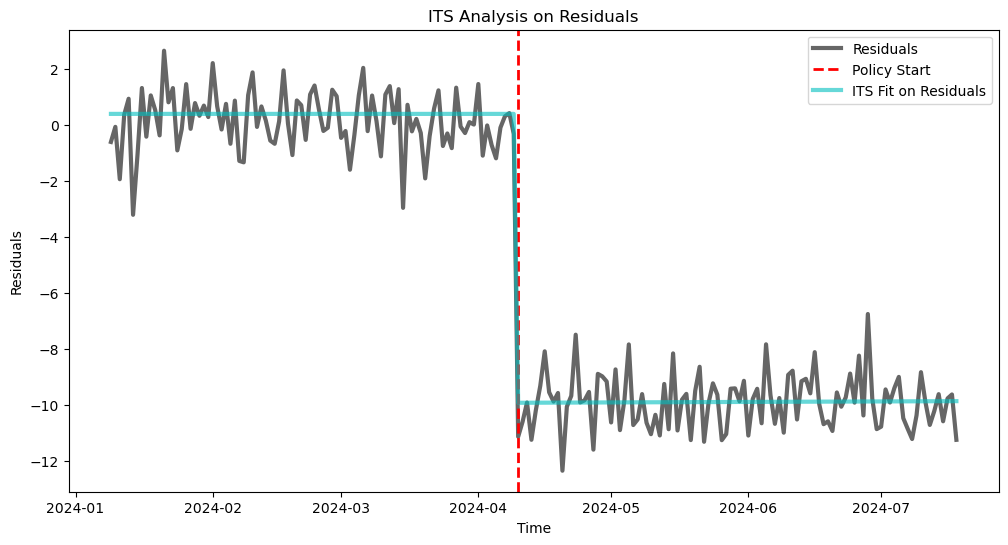

In [7]:
# Plot the residuals and the ITS fit
plt.figure(figsize=(12, 6))
plt.plot(its_data.index[8:], its_data['residuals'][8:], label='Residuals', lw=3, alpha=.6, c='k')
plt.axvline(its_data.index[policy_start], color='red', linestyle='--', label='Policy Start', lw=2)
plt.plot(its_data.index[8:], its_model_on_residuals.predict(X)[8:], color='c', label='ITS Fit on Residuals', lw=3, alpha=.6)
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.title('ITS Analysis on Residuals')
plt.legend()
plt.show()